In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.5.0+cu121


In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
#import torch_geometric
#from torch_geometric.loader import NeighborSampler
import torch.nn.functional as F

# Road Network as a Graph

In [ ]:
newyork = nx.readwrite.graphml.read_graphml('/content/newyork.graphml')
print(newyork)

MultiDiGraph named 'New York, USA' with 54128 nodes and 142123 edges


In [ ]:
newyork = nx.readwrite.graphml.read_graphml('newyork.graphml')
print(newyork)

MultiDiGraph named 'New York, USA' with 54128 nodes and 142123 edges


In [ ]:
newyork = nx.DiGraph(newyork)
print(newyork)

DiGraph named 'New York, USA' with 54128 nodes and 141673 edges


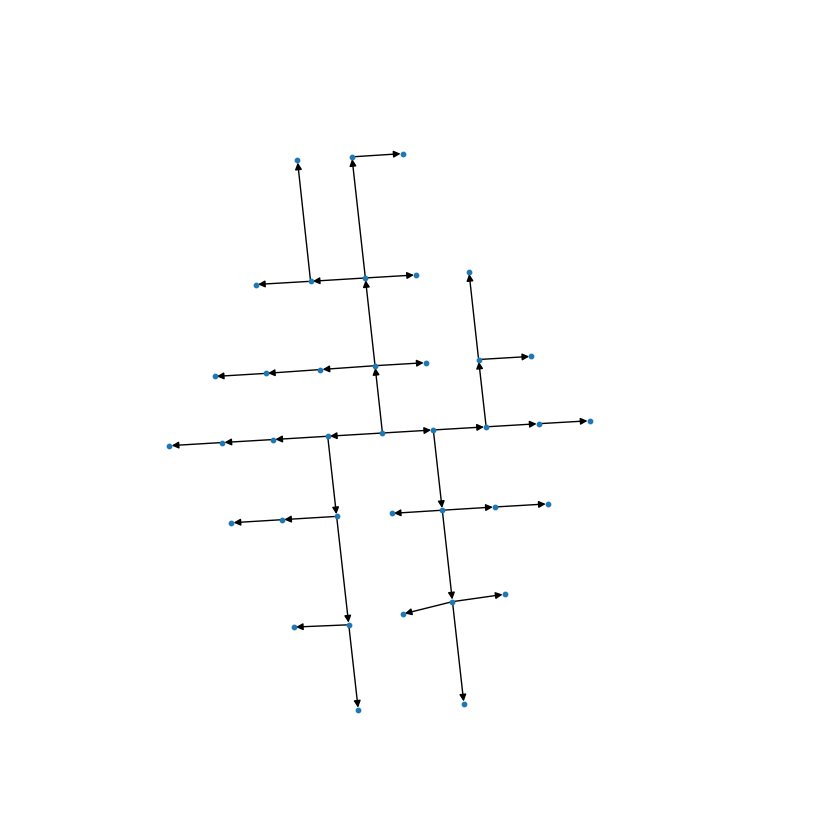

In [ ]:
edges_from_bfs = nx.algorithms.traversal.bfs_edges(newyork, '42467335', depth_limit=4)
subgraph = newyork.edge_subgraph(edges_from_bfs)
#using actual latitudes and longitudes
latitudes = [(u, y) for (u, y) in nx.get_node_attributes(subgraph, 'y').items()]
longitudes = [(u, x) for (u, x) in nx.get_node_attributes(subgraph, 'x').items()]
# latitudes and longitudes are stored as a strings, but nx pos needs floats.
pos = {u:(float(x),float(y)) for ((u,y), (u,x)) in zip(latitudes, longitudes)}
plt.figure(1, figsize=(8,8))
nx.draw(subgraph, pos=pos, node_size=10)
plt.show()

To view what intersection the central node corresponds to in the real world: checking  up the latitude and longitude from the node attribute dictionary.

In [ ]:
latitude = newyork.nodes['42467335']['y']
longitude = newyork.nodes['42467335']['x']
print("lat,lng is: {},{}".format(latitude, longitude))

lat,lng is: 40.655398,-73.929762


In [ ]:
# Node (Intersection) Features
all_node_keys = list(list(newyork.nodes[n].keys()) for n in newyork.nodes())
all_node_keys = set(np.concatenate(all_node_keys).flat)
all_node_keys

{'highway', 'osmid', 'ref', 'x', 'y'}

In [ ]:
# Edge (Road Segment) Features
all_edge_keys = list(list(newyork.edges[e].keys()) for e in newyork.edges())
all_edge_keys = set(np.concatenate(all_edge_keys).flat)
all_edge_keys

{'access',
 'bridge',
 'geometry',
 'highway',
 'key',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'ref',
 'service',
 'tunnel',
 'width'}

# Node Features


In [ ]:
# Average Degree (In "road network", the average degree will be from 2-4)
newyork.number_of_edges() / newyork.number_of_nodes()

2.6173699379249187

(array([4.5000e+01, 6.8900e+03, 0.0000e+00, 1.5394e+04, 0.0000e+00,
        2.3329e+04, 8.3500e+03, 0.0000e+00, 1.1200e+02, 8.0000e+00]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

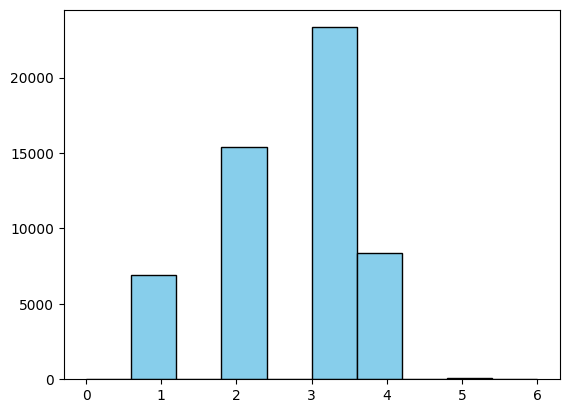

In [ ]:
# Histogram of out degree.
out_degrees = [v for (k,v) in newyork.out_degree]
plt.hist(out_degrees, color = 'skyblue', lw=1, ec="black")

# Dataset Statistics

This section will get you very familiar with the edge-level (or road-level) features present in the dataset.

In [ ]:
# A helper function to count the number of edges with a particular feature
def countEdgesWithFeature(feature_dict, feature_key):
  count = 0
  for k,v in feature_dict.items():
    if feature_key in v:
      count += 1
  return count

In [ ]:
# Total number of edges
E = len(newyork.edges())
print(E)

141673


In [ ]:
#for each attribute, the percent of edges which have the feature available

for attribute_name in all_edge_keys:
  count = countEdgesWithFeature(newyork.edges(), attribute_name)
  print("{}: {} (Percentage: {:.1%})".format(attribute_name, count, count/E))

name: 137766 (Percentage: 97.2%)
maxspeed: 7661 (Percentage: 5.4%)
tunnel: 177 (Percentage: 0.1%)
service: 17 (Percentage: 0.0%)
key: 141673 (Percentage: 100.0%)
lanes: 12808 (Percentage: 9.0%)
bridge: 2074 (Percentage: 1.5%)
oneway: 141673 (Percentage: 100.0%)
osmid: 141673 (Percentage: 100.0%)
ref: 3198 (Percentage: 2.3%)
access: 413 (Percentage: 0.3%)
highway: 141673 (Percentage: 100.0%)
geometry: 37222 (Percentage: 26.3%)
width: 33 (Percentage: 0.0%)
length: 141673 (Percentage: 100.0%)


In [ ]:
# create a dictionary mapping each edge feature to a dictionary of the values present.
edge_attribute_categorical = defaultdict(lambda: defaultdict(int))
road_lengths = []
for edge_attributes in newyork.edges.values():
  for attribute_name, attribute_value in edge_attributes.items():a
    if attribute_name in {"highway", "lanes", "maxspeed", "oneway"}:
      edge_attribute_categorical[attribute_name][attribute_value] += 1
    if attribute_name == "length":
      road_lengths.append(float(attribute_value))

In [ ]:
# Max Speed
edge_attribute_categorical["maxspeed"]

defaultdict(int,
            {'25 mph': 5553,
             '30 mph': 786,
             '45 mph': 80,
             '35 mph': 351,
             '10 mph': 1,
             '15 mph': 17,
             '120 mph': 4,
             '50 mph': 375,
             '20 mph': 362,
             '5 mph': 1,
             "[u'25 mph', u'40 mph']": 4,
             "[u'45 mph', u'50 mph']": 7,
             '40 mph': 99,
             "[u'25 mph', u'30 mph']": 5,
             "[u'55 mph', u'50 mph']": 4,
             "[u'35 mph', u'40 mph']": 1,
             "[u'40 mph', u'35 mph']": 1,
             '55 mph': 1,
             "[u'30 mph', u'40 mph']": 1,
             "[u'10 mph', u'40 mph']": 1,
             "[u'30 mph', u'35 mph']": 3,
             "[u'25 mph', u'39 mph']": 2,
             '39 mph': 2})

In [ ]:
# One-Way
edge_attribute_categorical["oneway"]

defaultdict(int, {'False': 104076, 'True': 37597})

(array([3.4600e+03, 6.2130e+03, 7.0000e+03, 7.3390e+03, 7.3010e+03,
        4.0601e+04, 1.2921e+04, 6.8250e+03, 5.3630e+03, 5.0190e+03,
        5.1760e+03, 4.6370e+03, 3.9900e+03, 3.4830e+03, 4.5420e+03,
        2.7770e+03, 3.9110e+03, 2.4290e+03, 1.8650e+03, 1.8490e+03,
        8.7200e+02, 5.9800e+02, 4.9300e+02, 2.9700e+02, 2.2300e+02,
        2.0100e+02, 1.4800e+02, 1.4300e+02, 1.4100e+02, 1.3200e+02,
        1.3800e+02, 1.0400e+02, 6.5000e+01, 8.9000e+01, 9.1000e+01,
        6.0000e+01, 7.0000e+01, 5.7000e+01, 5.9000e+01, 3.6000e+01,
        6.3000e+01, 5.3000e+01, 2.7000e+01, 3.6000e+01, 3.6000e+01,
        2.2000e+01, 2.6000e+01, 2.3000e+01, 2.3000e+01, 1.1000e+01]),
 array([  0.,  14.,  28.,  42.,  56.,  70.,  84.,  98., 112., 126., 140.,
        154., 168., 182., 196., 210., 224., 238., 252., 266., 280., 294.,
        308., 322., 336., 350., 364., 378., 392., 406., 420., 434., 448.,
        462., 476., 490., 504., 518., 532., 546., 560., 574., 588., 602.,
        616., 630., 64

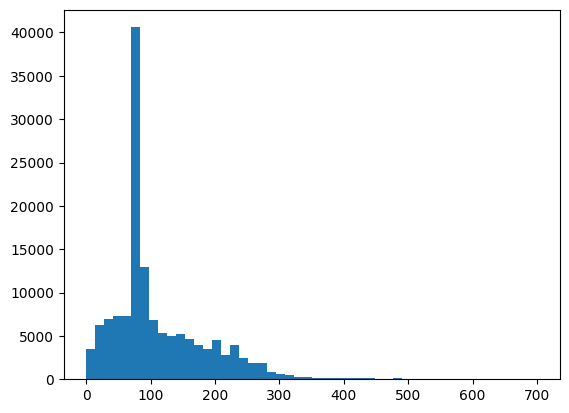

In [ ]:
# Road Length
plt.hist(road_lengths, bins=50, range=(0,700))

In [ ]:
# Compute mean and standard deviation of road length feature for normalization
# in the model
mean =  sum(road_lengths) / len(road_lengths)
stdev = (sum([((x - mean) ** 2) for x in road_lengths]) / len(road_lengths))**(0.5)
print("mean: ", mean, " and stdev: ", stdev)

mean:  118.59536848513265  and stdev:  108.47075106013754


## Betweenness Centrality



In [ ]:

manhatten = nx.readwrite.graphml.read_graphml('/content/manhatten.graphml')
manhatten = nx.DiGraph(manhatten)
betweenness_centrality = nx.algorithms.centrality.betweenness_centrality(manhatten)

In [ ]:
# Let's find the intersection in Manhatten that's on the most shortest paths!
betweenness_max_node = max(betweenness_centrality, key=betweenness_centrality.get)
print("Betweeness Centrality intersection is at: {},{}".format(manhatten.nodes[betweenness_max_node]['y'],
                                                               manhatten.nodes[betweenness_max_node]['x']))

Betweeness Centrality intersection is at: 40.7952534,-73.9732066


# Closeness Centrality



In [ ]:

closeness_centrality = nx.algorithms.centrality.closeness_centrality(manhatten)

In [ ]:
# intersection in Manhatten that's closest to all other intersections
closeness_max_node = max(closeness_centrality, key=closeness_centrality.get)
print("Closeness Centrality intersection is at: {},{}".format(manhatten.nodes[closeness_max_node]['y'],
                                                              manhatten.nodes[closeness_max_node]['x']))

Closeness Centrality intersection is at: 40.7474423,-73.9688174


The intersection is actually on the [outer edge](https://www.google.com/maps/place/40%C2%B044'50.8%22N+73%C2%B058'07.7%22W/@40.7335836,-73.9882072,12.8z/data=!4m5!3m4!1s0x0:0xaf0c4057ea31f7e9!8m2!3d40.7474423!4d-73.9688174) of Manhatten. However, it is on FDR Drive which is very well-connected to the rest of Manhatten. Out of sheer curiosity, let's find the intersection with the smallest closeness centrality importance.

In [ ]:
#intersection with the smallest closeness centrality importance.
closeness_min_node = min(closeness_centrality, key=closeness_centrality.get)
print("Closeness Centrality intersection is at: {},{}".format(manhatten.nodes[closeness_min_node]['y'],
                                                              manhatten.nodes[closeness_min_node]['x']))

Closeness Centrality intersection is at: 40.847668,-73.929669


In [ ]:
# intersections that are not only well-connected but also connected to other highly connected nodes
import networkx as nx

# Load the graph
manhatten = nx.readwrite.graphml.read_graphml('/content/manhatten.graphml')
manhatten = nx.DiGraph(manhatten)

# Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(manhatten, max_iter=1000)
eigenvector_max_node = max(eigenvector_centrality, key=eigenvector_centrality.get)
print("Eigenvector Centrality intersection is at: {},{}".format(
    manhatten.nodes[eigenvector_max_node]['y'], manhatten.nodes[eigenvector_max_node]['x']))




Eigenvector Centrality intersection is at: 40.8651,-73.921884


In [ ]:
# Bonacich Centrality using Katz Centrality approximation(reveals both primary and secondary nodes, providing  ideal locations to develop alternative or backup routes.)
alpha = 0.1
beta = 1.0   # Scaling factor for the influence of neighbours
bonacich_centrality = nx.katz_centrality(manhatten, alpha=alpha, beta=beta, max_iter=1000, tol=1e-6)
bonacich_max_node = max(bonacich_centrality, key=bonacich_centrality.get)
print("Bonacich Centrality intersection is at: {},{}".format(
    manhatten.nodes[bonacich_max_node]['y'], manhatten.nodes[bonacich_max_node]['x']))

Bonacich Centrality intersection is at: 40.864463,-73.918943


In [ ]:

# Katz Centrality
katz_centrality = nx.katz_centrality(manhatten, alpha=0.1, beta=1.0, max_iter=1000)
katz_max_node = max(katz_centrality, key=katz_centrality.get)
print("Katz Centrality intersection is at: {},{}".format(
    manhatten.nodes[katz_max_node]['y'],
    manhatten.nodes[katz_max_node]['x']
))



#ROBUSTNESS ANALYSIS

In [ ]:
manhattan_nodes = list(manhatten.nodes(data=True))


for i, (node_id, attrs) in enumerate(manhattan_nodes[:10]):
    print(f"Node {i}: ID = {node_id}, Attributes = {attrs}")

Node 0: ID = 42459137, Attributes = {'y': '40.7755735', 'x': '-73.9603796', 'osmid': '42459137', 'highway': 'traffic_signals'}
Node 1: ID = 1773060099, Attributes = {'y': '40.7137811', 'x': '-73.9980743', 'osmid': '1773060099', 'highway': 'traffic_signals'}
Node 2: ID = 373268484, Attributes = {'y': '40.7728065', 'x': '-73.9680288', 'osmid': '373268484'}
Node 3: ID = 42426374, Attributes = {'y': '40.7982104', 'x': '-73.9523942', 'osmid': '42426374', 'highway': 'traffic_signals'}
Node 4: ID = 42446849, Attributes = {'y': '40.7151089', 'x': '-74.0159512', 'osmid': '42446849'}
Node 5: ID = 42429100, Attributes = {'y': '40.856503', 'x': '-73.932761', 'osmid': '42429100'}
Node 6: ID = 42442764, Attributes = {'y': '40.852484', 'x': '-73.9276854', 'osmid': '42442764', 'highway': 'traffic_signals'}
Node 7: ID = 42452598, Attributes = {'y': '40.734896', 'x': '-74.003154', 'osmid': '42452598'}
Node 8: ID = 278609934, Attributes = {'y': '40.7096039', 'x': '-74.0015481', 'osmid': '278609934', 'hig

Using a sampled subgraph with 1000 nodes.
Calculating Degree Centrality...
Calculating Closeness Centrality...
Calculating Betweenness Centrality (Approx)...
Calculating Eigenvector Centrality...
Calculating Bonacich Centrality (Beta=0.5)...
Calculating Katz Centrality...


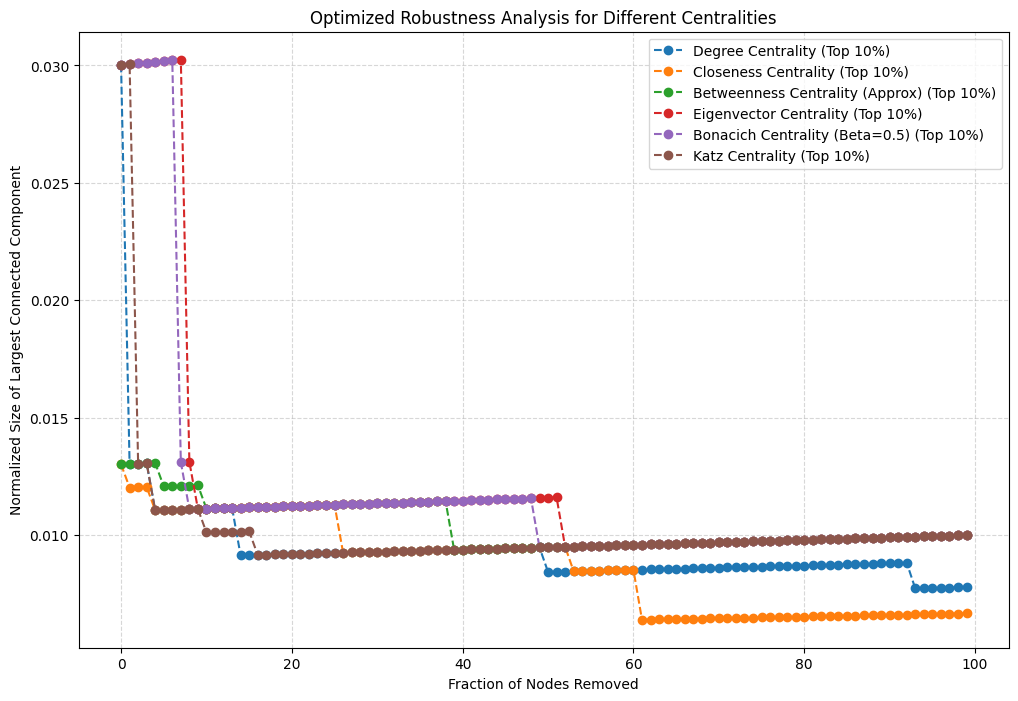

Using a sampled subgraph with 2000 nodes.
Calculating Degree Centrality...
Calculating Closeness Centrality...
Calculating Betweenness Centrality (Approx)...
Calculating Eigenvector Centrality...
Calculating Bonacich Centrality (Beta=0.5)...
Calculating Katz Centrality...


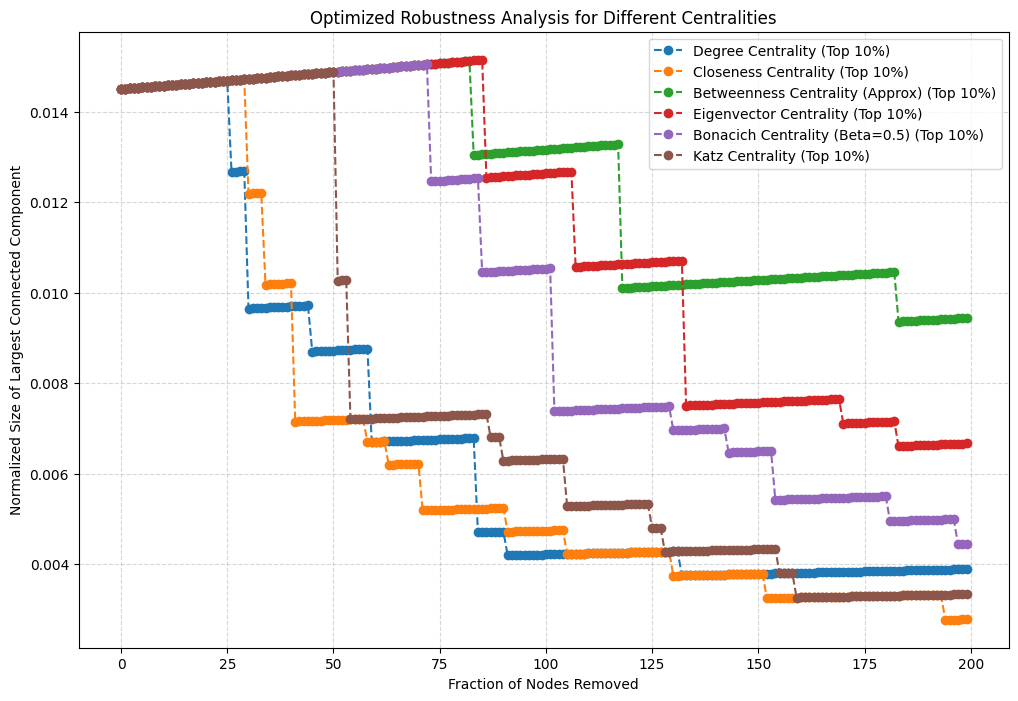

In [ ]:

def bonacich_centrality(graph, beta=1.0, max_iter=100, tol=1e-06):
    n = len(graph)
    A = nx.to_numpy_array(graph)
    centrality = np.ones(n)
    for _ in range(max_iter):
        last_centrality = centrality
        centrality = beta * A @ centrality + 1
        if np.linalg.norm(centrality - last_centrality, ord=1) < tol:
            break
    return dict(zip(graph.nodes(), centrality))

def optimized_robustness_analysis(graph, centrality_measures, top_fraction=0.1, sample_size=1000):
    if sample_size and graph.number_of_nodes() > sample_size:
        nodes_sample = list(graph.nodes())[:sample_size]
        graph = graph.subgraph(nodes_sample).copy()
        print(f"Using a sampled subgraph with {graph.number_of_nodes()} nodes.")

    plt.figure(figsize=(12, 8))

    for centrality_name, centrality_func in centrality_measures.items():
        print(f"Calculating {centrality_name}...")
        try:
            centrality = centrality_func(graph)
        except Exception as e:
            print(f"Skipping {centrality_name} due to error: {e}")
            continue

        sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)

        lcc_sizes = []

        temp_graph = graph.copy()

        num_nodes_to_remove = int(top_fraction * len(sorted_nodes))
        for i, node in enumerate(sorted_nodes[:num_nodes_to_remove]):
            temp_graph.remove_node(node)
            if temp_graph.number_of_nodes() > 0:
                lcc = max(nx.strongly_connected_components(temp_graph), key=len)
                lcc_sizes.append(len(lcc) / temp_graph.number_of_nodes())
            else:
                lcc_sizes.append(0)

        plt.plot(
            lcc_sizes,
            label=f"{centrality_name} (Top {int(top_fraction * 100)}%)",
            linestyle='--',
            marker='o'
        )

    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Normalized Size of Largest Connected Component")
    plt.title("Optimized Robustness Analysis for Different Centralities")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

centrality_measures = {
    "Degree Centrality": nx.degree_centrality,
    "Closeness Centrality": nx.closeness_centrality,
    "Betweenness Centrality (Approx)": lambda g: nx.betweenness_centrality(g, k=min(50, g.number_of_nodes() // 2), seed=42),
    "Eigenvector Centrality": lambda g: nx.eigenvector_centrality(g, max_iter=1000),
    "Bonacich Centrality (Beta=0.5)": lambda g: bonacich_centrality(g, beta=0.5),
    "Katz Centrality": lambda g: nx.katz_centrality(g, alpha=0.1, beta=1.0, max_iter=1000)
}

optimized_robustness_analysis(manhatten, centrality_measures, sample_size=1000)

optimized_robustness_analysis(newyork, centrality_measures, sample_size=2000)


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=538974 sha256=f015ae94c1ca1065b5d695ed66cf2d2945e9accdde8f0f95084ace0263dd8558
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1104576 sha256=0168511f74056403073ff4cc7abf48573384a1b5e9009be0828d20af4e3fca30
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built